In [29]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import gutenberg, stopwords
from collections import Counter
%matplotlib inline

In [100]:
lines = "The Lumberjack Song is the funniest Monty Python bit: I can't think of it without laughing. I would rather put strawberries on my ice cream for dessert, they have the best taste. The taste of caramel is a fantastic accompaniment to tasty mint ice cream."


In [101]:
nlp = spacy.load('en')
lines_doc = nlp(lines)

In [102]:
lines_doc

The Lumberjack Song is the funniest Monty Python bit: I can't think of it without laughing. I would rather put strawberries on my ice cream for dessert, they have the best taste. The taste of caramel is a fantastic accompaniment to tasty mint ice cream.

In [104]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

emma = gutenberg.paras('austen-emma.txt')

emma_paras = []
for paragraph in emma:
    para = paragraph[0]
    para = [re.sub(r'--','',word) for word in para]
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/salilketkar/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/salilketkar/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5,
                           min_df = 2,
                           stop_words = 'english',
                           lowercase=True,
                           use_idf = True,
                           norm=u'l2',
                           smooth_idf=True)

emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('Number of features: %d' % emma_paras_tfidf.get_shape()[1])

X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

X_Train_tfidf_csr = X_train_tfidf.tocsr()

n = X_Train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]

terms = vectorizer.get_feature_names()

for i, j in zip(*X_Train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_Train_tfidf_csr[i,j]

print('Original Sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original Sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [115]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)

paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.21633961691403
Component 0
" Oh !"    0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
" Oh !     0.999289
" Oh !     0.999289
Name: 0, dtype: float64
Component 1
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.635162
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.593215
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.570563
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton 

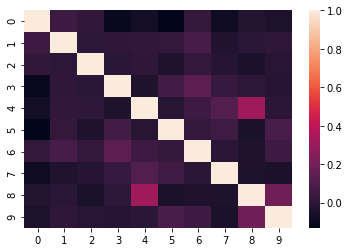

Key
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being 

In [117]:
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10,0:10]

ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

print('Key')
for i in range(10):
    print(i, sim_matrix.index[i])

## Challenge 0

In [119]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)

paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 49.38420187181725
Component 0
" Oh !     0.999919
" Oh !     0.999919
" Oh !     0.999919
" Oh !     0.999919
" Oh !"    0.999919
" Oh !     0.999919
" Oh !     0.999919
" Oh !     0.999919
" Oh !     0.999919
" Oh !     0.999919
Name: 0, dtype: float64
Component 1
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.615199
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                         

The test model does not identify similar components than the train model

## Challenge 1

Go back up to the code where we originally translated the text from words to numbers. There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well. We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities. Change things up a few times and see how that affects the results of the LSA. Write up your observations and share them with your mentor.

In [120]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.33,
                           min_df = 3,
                           stop_words = 'english',
                           lowercase=False,
                           use_idf = True,
                           norm=u'l2',
                           smooth_idf=True)

emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('Number of features: %d' % emma_paras_tfidf.get_shape()[1])

X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

X_Train_tfidf_csr = X_train_tfidf.tocsr()

n = X_Train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]

terms = vectorizer.get_feature_names()

for i, j in zip(*X_Train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_Train_tfidf_csr[i,j]

print('Original Sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1437
Original Sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [130]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.75,
                           min_df = 1,
                           stop_words = None,
                           lowercase=True,
                           use_idf = True,
                           norm=u'l1',
                           smooth_idf=False)

emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('Number of features: %d' % emma_paras_tfidf.get_shape()[1])

X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

X_Train_tfidf_csr = X_train_tfidf.tocsr()

n = X_Train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]

terms = vectorizer.get_feature_names()

for i, j in zip(*X_Train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_Train_tfidf_csr[i,j]

print('Original Sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 4103
Original Sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'trial': 0.1821170903721988, 'completed': 0.1821170903721988, 'minutes': 0.11991553156067196, 'present': 0.11793656908569662, 'however': 0.10714219195096059, 'more': 0.08236932579933674, 'few': 0.10604912955905095, 'very': 0.060192016074104904, 'the': 0.04216105522578056}


In [131]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5,
                           min_df = 2,
                           stop_words = None,
                           lowercase=True,
                           use_idf = True,
                           norm=u'l2',
                           smooth_idf=False)

emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('Number of features: %d' % emma_paras_tfidf.get_shape()[1])

X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

X_Train_tfidf_csr = X_train_tfidf.tocsr()

n = X_Train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]

terms = vectorizer.get_feature_names()

for i, j in zip(*X_Train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_Train_tfidf_csr[i,j]

print('Original Sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 2178
Original Sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.4769984658415389, 'present': 0.4691265742505517, 'however': 0.4261888391133901, 'more': 0.3276476493689768, 'few': 0.42184086952826444, 'very': 0.23943103073958805, 'the': 0.16770770557592504}
